In [38]:
import math
from math import sqrt
import argparse

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

# vision imports

from torchvision import transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from torchvision import datasets
import torch.nn.functional as F

# dalle classes

from dalle_pytorch import DiscreteVAE
import os
import matplotlib.pyplot as plt

In [39]:
from torchvision.datasets import CocoCaptions

In [40]:
val_coco = CocoCaptions('/vision/7052107/Dalle/coco/val2017', '/vision/7052107/Dalle/coco/annotations/captions_val2017.json')

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


In [41]:
for idx, i in enumerate(val_coco):
    if idx == 5:
        break

In [42]:
plt.rcParams["figure.figsize"] = (10,6)

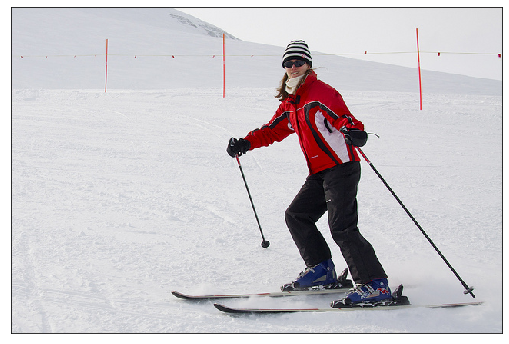

A woman posing for the camera standing on skis.
a woman standing on skiis while posing for the camera
A woman in a red jacket skiing down a slope
A young woman is skiing down the mountain slope. 
a person on skis makes her way through the snow


In [43]:
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.imshow(i[0])
plt.show()
for j in i[1]:
    print(j)

In [44]:
gpu_id = 6
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
use_cuda = torch.cuda.is_available()
print("GPU device %d:" %(gpu_id), use_cuda)

GPU device 6: True


In [45]:
# constants
IMAGE_SIZE = 128
IMAGE_PATH = '/vision/7052107/Dalle/2D-Shape-Generator/output6_img/'

EPOCHS = 30
BATCH_SIZE = 1
LEARNING_RATE = 1e-3
LR_DECAY_RATE = 0.98

NUM_TOKENS = 32
NUM_LAYERS = 2
NUM_RESNET_BLOCKS = 2
SMOOTH_L1_LOSS = False
EMB_DIM = 512
HID_DIM = 256
KL_LOSS_WEIGHT = 0

STARTING_TEMP = 1.
TEMP_MIN = 0.5
ANNEAL_RATE = 1e-6

NUM_IMAGES_SAVE = 4

# data
print(IMAGE_PATH)
ds = ImageFolder(
    IMAGE_PATH,
    T.Compose([
#         T.Resize(IMAGE_SIZE),
#         T.CenterCrop(IMAGE_SIZE),
        T.ToTensor(),
        #T.Normalize((128,) * 3, (128,) * 3)
#         T.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
)


/vision/7052107/Dalle/2D-Shape-Generator/output6_img/


In [46]:
ds

Dataset ImageFolder
    Number of datapoints: 43000
    Root location: /vision/7052107/Dalle/2D-Shape-Generator/output6_img/
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [47]:
import argparse
from pathlib import Path
from tqdm import tqdm

# torch

import torch

from einops import repeat

# vision imports

from PIL import Image
from torchvision.utils import make_grid, save_image

# dalle related classes and utils

from dalle_pytorch import OpenAIDiscreteVAE, DiscreteVAE, DALLE
from dalle_pytorch.simple_tokenizer import tokenize, tokenizer, VOCAB_SIZE


In [48]:
vae_path = Path('./save/1/vae-final.pt')
dalle_path = Path('./save/1/dalle-final.pt')

load_obj = torch.load(str(dalle_path))
dalle_params, vae_params, weights = load_obj.pop('hparams'), load_obj.pop('vae_params'), load_obj.pop('weights')

In [49]:
vae_obj = torch.load(str(vae_path))

In [50]:
vae_only = DiscreteVAE(**vae_obj['hparams'])
vae_only.cuda()
vae_only.load_state_dict(vae_obj['weights'])

<All keys matched successfully>

In [51]:
vae = DiscreteVAE(**vae_params)
# vae = OpenAIDiscreteVAE()



In [59]:
dalle = DALLE(**dalle_params).cuda()


In [53]:
dalle.load_state_dict(weights)

<All keys matched successfully>

In [22]:
from PIL import Image
import numpy as np
from torchvision.transforms import ToTensor
image = Image.open('/vision/7052107/Dalle/2D-Shape-Generator/output6/ellipse_red_1.jpg')

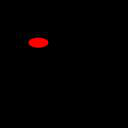

In [23]:
image

In [15]:
out = vae_only(ToTensor()(image).cuda().unsqueeze(0))

In [16]:
out.shape

tensor([[[[-1.4427e-02, -3.2555e-03, -7.7944e-03,  ..., -6.1870e-03,
           -6.1230e-03, -1.5920e-02],
          [-4.5421e-03, -4.5499e-03, -4.9343e-03,  ..., -9.1203e-03,
           -3.6453e-03, -9.5271e-03],
          [-6.9706e-03, -2.8394e-03, -6.3918e-03,  ..., -2.1177e-03,
           -1.9288e-03, -7.9140e-03],
          ...,
          [-6.3745e-03, -4.3690e-03, -6.8135e-03,  ..., -3.1763e-03,
           -3.1904e-03, -1.1185e-02],
          [-9.6005e-03, -5.8578e-03, -7.3856e-03,  ...,  8.4750e-04,
           -5.3200e-03, -8.1457e-03],
          [-1.6176e-02, -9.1875e-03, -7.1999e-03,  ..., -4.7899e-03,
           -8.1056e-03, -1.5666e-02]],

         [[-2.8240e-04,  1.4479e-03, -1.8466e-04,  ...,  1.1794e-03,
           -8.2691e-04, -4.4996e-04],
          [-1.7870e-03, -3.4735e-03, -4.2954e-03,  ..., -1.8907e-03,
            1.1469e-03,  2.1159e-04],
          [ 3.4540e-03, -3.9710e-03, -3.5273e-03,  ..., -3.8830e-03,
            1.3522e-03, -5.8495e-04],
          ...,
     

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


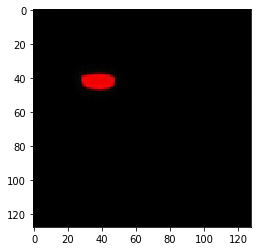

In [17]:
plt.imshow(abs(out.squeeze().detach().cpu().numpy().swapaxes(0,1).swapaxes(1,2)))

In [14]:
sentence = 'poly3 is red'
image_size = vae.image_size
text = tokenize([sentence], dalle.text_seq_len).cuda()
text = repeat(text, '() n -> b n', b = 4)
outputs = []

In [18]:
dalle.text_seq_len

256

In [16]:
text.shape

torch.Size([4, 256])

In [20]:
for text_chunk in tqdm(text.split(4), desc = 'generating images'):
    output = dalle.generate_images(text_chunk, filter_thres = 0.5)
    outputs.append(output)

outputs = torch.cat(outputs)

generating images: 100%|██████████| 1/1 [00:35<00:00, 35.70s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


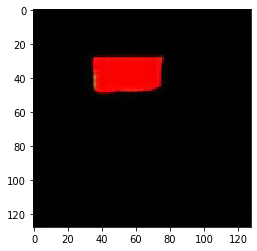

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


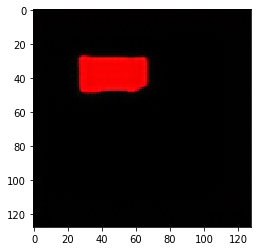

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


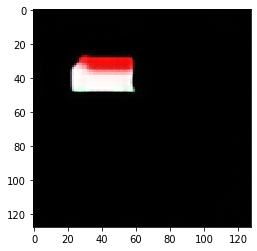

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


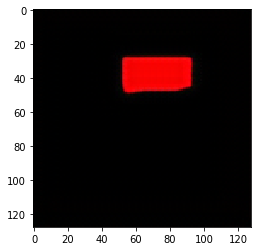

In [22]:
for out in outputs:
    plt.imshow(abs(out.cpu().numpy().swapaxes(0,1).swapaxes(1,2)))
    plt.show()

In [37]:
dalle.image_emb(dalle.vae.get_codebook_indices(ToTensor()(image).cuda().unsqueeze(0)))

tensor([[[ 1.4635,  0.5432,  0.4525,  ...,  0.0370, -1.3333,  0.6481],
         [-0.3715,  0.3518,  0.0519,  ..., -0.7149,  0.7975,  0.3590],
         [-0.3715,  0.3518,  0.0519,  ..., -0.7149,  0.7975,  0.3590],
         ...,
         [ 0.7417,  0.5861, -0.0163,  ...,  0.2646,  1.3129, -0.9363],
         [ 1.1114,  1.3373,  0.2073,  ...,  0.6587,  0.6149,  1.2812],
         [-0.3987,  0.7460, -0.7455,  ..., -2.2496,  0.5459, -0.6733]]],
       device='cuda:0', grad_fn=<EmbeddingBackward>)

In [24]:
vae, text_seq_len, image_seq_len, num_text_tokens = dalle.vae, dalle.text_seq_len, dalle.image_seq_len, dalle.num_text_tokens
total_seq_len = text_seq_len + image_seq_len
total_len = text_seq_len + image_seq_len

In [25]:
print(text_seq_len, image_seq_len, num_text_tokens)

256 1024 49408


In [26]:
def default(val, d):
    return val if val is not None else d

In [92]:
out = text_chunk
cur = 256

In [ ]:
cur+=1
for cur_len in range(cur, total_len):
    # text_seq = 256, image_seq = 1024(32x32), num_text_tokens = 49408, num_img_tokens = 8192
    is_image = cur_len >= text_seq_len
    text, image = out[:, :text_seq_len], out[:, text_seq_len:]
    
    # dalle forward
    text_range = torch.arange(text_seq_len, device='cuda') + (num_text_tokens - text_seq_len)
    text = torch.where(text == 0, text_range, text)
    text = F.pad(text, (1, 0), value = 0) # use padding as <bos> # (iter, 256) --> (iter, 257)
    tokens = dalle.text_emb(text)
    tokens += dalle.text_pos_emb(torch.arange(text.shape[1], device='cuda'))
    seq_len = tokens.shape[1] # 257
    
    # if image --> out concat 256 --> 704 (+448)
    if (image is not None) and (not image.nelement() == 0):
        is_raw_image = len(image.shape) == 4
        if is_raw_image:
            image_size = dalle.vae.image_size
            
            # (1, 1024) <-- encoder output argmax: encoder outputs=(bs, 8192, 32, 32)=(bs, 8192,32*32)
            indices = dalle.vae.get_codebook_indices(image) # image token argmax
            
        #################################################################
        image_len = image.shape[1]
        image_emb = dalle.image_emb(image)
        image_emb += dalle.image_pos_emb(image_emb)
        tokens = torch.cat((tokens, image_emb), dim=1)
        seq_len += image_len
        #################################################################
            
    # remove the last token
    if tokens.shape[1] > total_seq_len:
        seq_len -= 1
        tokens = tokens[:,:-1]
            
    tr_out = dalle.transformer(tokens) # (bs, 257, 512)
    logits = dalle.to_logits(tr_out) # (bs, 257, 57600) = (num_text_tokens + num_img_tokens)
    logits = logits.detach().cpu()
    logits_mask = dalle.logits_mask[:, :seq_len].detach().cpu() # masking
    max_neg_value = -torch.finfo(logits.dtype).max
    logits.masked_fill_(logits_mask, max_neg_value) # neg
    
    # final 257 --> 1
    logits = logits[:,-1,:] # (bs, 57600)
    
    num_logits = logits.shape[-1]
    k = max(int((1-0.5)*num_logits), 1)
    
    # value, index
    # 해당 matrix에서 dimension으로 k개 만큼 가져오기 / index
    val, ind = torch.topk(logits, k)  # (bs, 57600/k)
    
    probs = torch.full_like(logits, float('-inf')) # (bs, 57600)
    probs.scatter_(1, ind, val)
    filtered_logits = probs
    probs = F.softmax(filtered_logits / 0.9, dim=-1) # (bs, 57600)
    
    ################################################################################################
    sample = torch.multinomial(probs, 1) # (bs, 1) # sample 1 token for entire tokens (img + text)
    ################################################################################################
    
    sample -= (num_text_tokens if is_image else 0) # subtract text token numbers
    out = torch.cat((out, sample.cuda()), dim=-1)
    
    if out.shape[1] <= text_seq_len:
        mask = F.pad(mask, (0, 1), value=True)
    
    same = out[0] == out[1]
    print(sample)
#     print(out)
#     print(cur_len, same[same==False])

tensor([[1908],
        [1908],
        [1908],
        [1908]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [5341],
        [5341],
        [5341]])
tensor([[5341],
        [

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


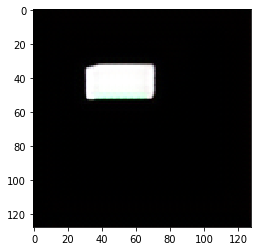

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


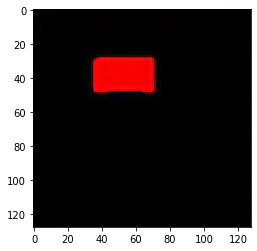

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


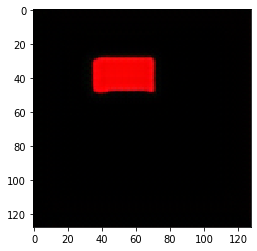

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


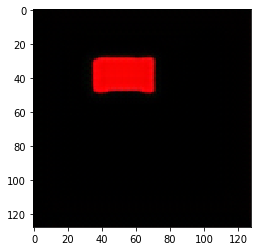

In [91]:
text_seq = out[:, :text_seq_len]
img_seq = out[:, -image_seq_len:]
images = dalle.vae.decode(img_seq)
for i in images:
    plt.imshow(abs(i.cpu().detach().numpy().swapaxes(0,1).swapaxes(1,2)))
    plt.show()

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.int32)

In [134]:
image = outputs
indices = dalle.vae.get_codebook_indices(image) # image token argmax
num_img_tokens = default(None, int(0.4375 * image_seq_len)) # 448 <-- 1024(32x32)
indices = indices[:, :num_img_tokens] # (bs, 448)
out = torch.cat((out, indices), dim=-1)

In [107]:
dummy2 = dalle.vae.encoder(outputs[[0]])
dummy2.shape

torch.Size([1, 8192, 32, 32])

In [135]:
out.shape

torch.Size([4, 704])

In [36]:
logits.shape

torch.Size([4, 257, 57600])

In [137]:
tokens.shape

torch.Size([4, 257, 512])

In [139]:
logits.shape

torch.Size([4, 57600])

In [138]:
tr_out.shape

torch.Size([4, 257, 512])

In [40]:
out = out.detach().cpu()

In [154]:
out[1]

tensor([1020,  339,  533,  736,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

tensor([[[-7.5396e+00, -7.6091e+00, -7.5549e+00,  ..., -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-6.1258e+00, -4.9597e+00, -5.0315e+00,  ..., -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-4.5771e+00, -5.2935e+00, -4.9975e+00,  ..., -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         ...,
         [-5.7719e+00, -5.8533e+00, -5.4025e+00,  ..., -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-4.7951e+00, -5.2463e+00, -6.4928e+00,  ..., -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-3.4028e+38, -3.4028e+38, -3.4028e+38,  ..., -3.9533e+00,
          -3.4941e+00, -3.9938e+00]],

        [[-7.5396e+00, -7.6091e+00, -7.5549e+00,  ..., -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-6.1258e+00, -4.9597e+00, -5.0315e+00,  ..., -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         [-4.5771e+00, -5.2935e+00, -4.9975e+00,  ..., -3.4028e+38,
          -3.4028e+38, -3.4028e+38],
         ...,
         [-5.7719e+00, -5

28800

In [46]:
ind.shape

torch.Size([4, 28800])

tensor([[   -inf,    -inf,    -inf,  ..., -3.9533, -3.4941, -3.9938],
        [   -inf,    -inf,    -inf,  ..., -3.9533, -3.4941, -3.9938],
        [   -inf,    -inf,    -inf,  ..., -3.9533, -3.4941, -3.9938],
        [   -inf,    -inf,    -inf,  ..., -3.9533, -3.4941, -3.9938]])

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2243e-11, 2.0392e-11,
         1.1704e-11],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2243e-11, 2.0392e-11,
         1.1704e-11],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2243e-11, 2.0392e-11,
         1.1704e-11],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2243e-11, 2.0392e-11,
         1.1704e-11]])

In [64]:
sample

tensor([[51316],
        [51316],
        [51316],
        [51316]])

In [56]:
import torchinfo
torchinfo.summary(dalle.vae)

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         4,194,304
├─Sequential: 1-2                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  12,544
|    |    └─ReLU: 3-2                    --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-3                  1,048,832
|    |    └─ReLU: 3-4                    --
|    └─ResBlock: 2-3                     --
|    |    └─Sequential: 3-5              1,245,952
|    └─ResBlock: 2-4                     --
|    |    └─Sequential: 3-6              1,245,952
|    └─Conv2d: 2-5                       2,105,344
├─Sequential: 1-3                        --
|    └─Conv2d: 2-6                       131,328
|    └─ResBlock: 2-7                     --
|    |    └─Sequential: 3-7              1,245,952
|    └─ResBlock: 2-8                     --
|    |    └─Sequential: 3-8              1,245,952
|    └─Sequential: 2-9                   --
|    |    └─C

Layer (type:depth-idx)                   Param #
├─Embedding: 1-1                         4,194,304
├─Sequential: 1-2                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  12,544
|    |    └─ReLU: 3-2                    --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-3                  1,048,832
|    |    └─ReLU: 3-4                    --
|    └─ResBlock: 2-3                     --
|    |    └─Sequential: 3-5              1,245,952
|    └─ResBlock: 2-4                     --
|    |    └─Sequential: 3-6              1,245,952
|    └─Conv2d: 2-5                       2,105,344
├─Sequential: 1-3                        --
|    └─Conv2d: 2-6                       131,328
|    └─ResBlock: 2-7                     --
|    |    └─Sequential: 3-7              1,245,952
|    └─ResBlock: 2-8                     --
|    |    └─Sequential: 3-8              1,245,952
|    └─Sequential: 2-9                   --
|    |    └─C

torch.Size([4, 1])